In [1]:
# os.environ['SPARK_HOME'] = '/usr/local/bin/spark-latest/spark-1.4.1-bin-hadoop2.6'

import os
#import sys
import glob
import re
import math
import numpy as np
import matplotlib.pyplot as plt # http://matplotlib.org/users/customizing.html
#import operator
from operator import add
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
#from ast import literal_eval

# Line below is not necessary, as Spark shell pre-loads the SparkContext sc object
# sc = SparkContext( 'local', 'pyspark')

%matplotlib inline

# TODO: Might need to export set SPARK_HOME etc. to point to latest install! But how to make permanent?
# This is set too late!
# os.environ['SPARK_HOME'] = '/usr/local/bin/spark-latest/spark-1.4.1-bin-hadoop2.6'
spark_home = os.environ.get('SPARK_HOME', None)
print('SPARK initialized OK! The SPARK home directory is ' + spark_home)
# Get the Spark version number from the SparkContext (getSparkContext().version())
# sc.version.split("\\.")
print 'Spark version is {0}'.format(sc.version)

sqlContext.setConf("spark.sql.codegen", "true")
sqlContext.setConf("spark.sql.unsafe.enabled", "true") # Project Tungsten - experimental!
sqlContext.setConf("spark.shuffle.manager", "tungsten-sort")

SPARK initialized OK! The SPARK home directory is /usr/local/bin/spark-1.3.1-bin-hadoop2.6
Spark version is 1.3.1


In [6]:
# https://spark.apache.org/docs/latest/sql-programming-guide.html
# TODO: Get the file into HDFS!
# data = sc.textFile('hdfs://(...)\moves_activities_3.csv')
data = sc.textFile('/home/vagrant/data/terje/moves_activities_3.csv')
# Get a file to play around with data frames on
print data.take(2)
# Convert each line into a tuple
parts = data.map(lambda l: l.split(","))
print parts.take(3)
# Columns: id,Date,Activity,Group,Start,End,Duration,Distance,Steps,Calories
activities = parts.map(lambda p: [p[0],p[1],p[2],p[3],p[4],p[5],int(p[6]),float(p[7]),int(p[8]),p[9]]) \
                       .filter(lambda p: p[2] == 'walking')

schema = StructType([ \
    StructField("id", StringType(), True), \
    StructField("date", StringType(), True), \
    StructField("activity", StringType(), True), \
    StructField("group", StringType(), True), \
    StructField("start", StringType(), True), \
    StructField("end", StringType(), True), \
    StructField("duration", IntegerType(), True), \
    StructField("distance", FloatType(), True), \
    StructField("steps", IntegerType(), True), \
    StructField("calories", StringType(), True)])

activities_df = sqlContext.createDataFrame(activities, schema)

# Register the DataFrame as a table
activities_df.registerTempTable('activities')

# SQL can be run over DataFrames that have been registered as a table
results = sqlContext.sql('SELECT date, steps, duration, distance FROM activities ORDER BY steps DESC')

# The results of SQL queries are RDDs and support all the normal RDD operations
steps = results.map(lambda p: 'Date: ' + str(p.date) + ' Steps: ' + str(p.steps) + ' Duration: ' + str(p.duration) + \
                   ' Distance: ' + str(np.round(p.distance, 2)) + ' km')
for step in steps.collect()[0:5]:
  print step   

[u'1,23.10.2014,walking,walking,2014-10-23T15:30:26+02:00,2014-10-23T15:39:35+02:00,549,0.654,909,0', u'2,23.10.2014,transport,transport,2014-10-23T15:44:24+02:00,2014-10-23T17:18:30+02:00,5646,94.734,0,0']
[[u'1', u'23.10.2014', u'walking', u'walking', u'2014-10-23T15:30:26+02:00', u'2014-10-23T15:39:35+02:00', u'549', u'0.654', u'909', u'0'], [u'2', u'23.10.2014', u'transport', u'transport', u'2014-10-23T15:44:24+02:00', u'2014-10-23T17:18:30+02:00', u'5646', u'94.734', u'0', u'0'], [u'3', u'23.10.2014', u'walking', u'walking', u'2014-10-23T17:24:20+02:00', u'2014-10-23T17:26:55+02:00', u'155', u'0.170', u'226', u'0']]
Date: 16.11.2014 Steps: 6223 Duration: 3331 Distance: 4.88km
Date: 09.11.2014 Steps: 5267 Duration: 3191 Distance: 4.45km
Date: 09.11.2014 Steps: 4468 Duration: 2643 Distance: 3.57km
Date: 07.11.2014 Steps: 2747 Duration: 1442 Distance: 2.22km
Date: 31.10.2014 Steps: 2584 Duration: 1370 Distance: 2.09km


In [8]:
# http://matplotlib.org/examples/pylab_examples/line_styles.html
def display_steps(steps_display, n):
    date = [d for (d, s) in steps_display][0:n]
    steps = [s for (d, s) in steps_display][0:n]

    fig, axes = plt.subplots(figsize=(16, 4), frameon=False, facecolor='white', edgecolor='white')
    plt.axis([-0.2, n, 0, max(steps)+200])
    plt.grid(b=True, which='major', axis='both')
    plt.xlabel('Date')
    plt.ylabel('Steps')
    plt.plot(steps, color='#00bbaa', marker='o')

    y_axis_interval = int(math.floor(max(steps) / 5))
    for axis, ticks in [(axes.get_xaxis(), range(0, n)), (axes.get_yaxis(), range(0, max(steps), y_axis_interval))]:
            axis.set_ticks_position('none')
            axis.set_ticks(ticks)
            #axis.label.set_color('#666666')
            axis.label.set_fontsize(12)

    axes.set_title('Walking, steps', fontsize=16)
    axes.set_xticklabels(date, rotation=35, ha='right', fontsize=9)
    plt.show()

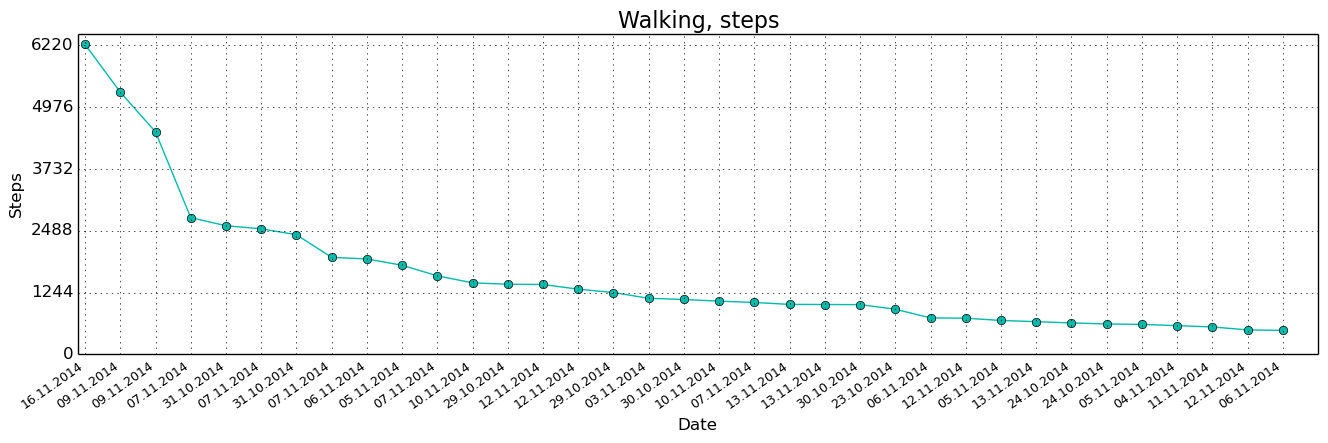

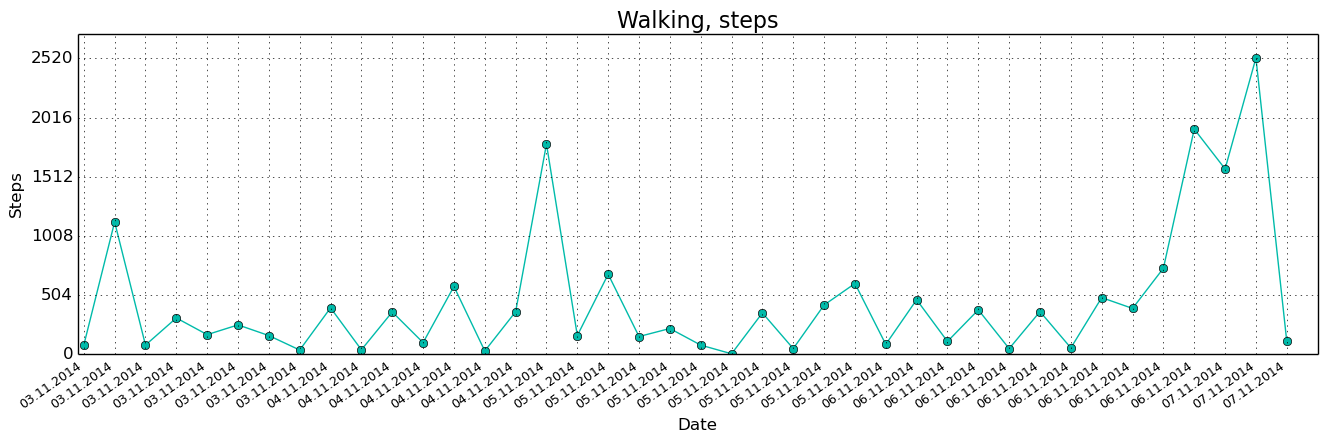

In [9]:
# NOTE: There are 105 steps
steps_display = results.map(lambda p: (p.date, p.steps)).collect()

display_steps(steps_display, 35)

results = sqlContext.sql('SELECT date, steps FROM activities ORDER BY date')
steps_display = results.map(lambda p: (p.date, p.steps)).collect()

display_steps(steps_display, 40)

In [2]:
# SERDE formats:
# http://wiki.apache.org/hadoop/Hive/DeveloperGuide
# a = LOAD 'iis.log' USING PigStorage(' ') AS
# (date:chararray, time:chararray, s_ip:chararray, cs_method:chararray, cs_uri_stem:chararray,
#     cs_uri_query:chararray, s_port:chararray, cs_username:chararray, c_ip:chararray,
#     cs_user_agent:chararray, sc_status:chararray, sc_substatus:chararray,
#    sc_win32_status:chararray);

sqlContext.sql("DROP TABLE IF EXISTS access_logs")

sqlContext.sql("CREATE EXTERNAL TABLE access_logs (date STRING, time STRING, s_ip STRING, cs_method STRING, " + \
               "cs_uri_stem STRING, cs_uri_query STRING, s_port STRING, cs_username STRING, c_ip STRING, " + \
               "cs_user_agent STRING, sc_status STRING, sc_substatus STRING, sc_win32_status STRING) " + \
               "ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.RegexSerDe' " + \
               "WITH SERDEPROPERTIES('input.regex'='^(\\S+) (\\S+) (\\S+) (\\S+) (\\S+) (\\S+) (\\S+) (\\S+) " + \
               "(\\S+) (\\S+) (\\S+) (\\S+) (\\S+)', " + \
               "'output.format.string'='%1$s %2$s %3$s %4$s %5$s %6$s %7$ %8$ %9$ %10$ %11$ %12$ %13$' )" + \
               "STORED AS TEXTFILE LOCATION '/home/vagrant/data/terje/access_logs'")

#sqlContext.sql("IMPORT EXTERNAL TABLE access_logs FROM '/home/vagrant/data/terje/iis.log' " + \
#               "LOCATION '/home/vagrant/data/terje/access_logs'")

sqlContext.sql("LOAD DATA LOCAL INPATH '/home/vagrant/data/terje/iis.log' OVERWRITE INTO TABLE access_logs")

DataFrame[result: string]

In [30]:
usernames = sqlContext.sql("SELECT * FROM access_logs")
usernames.head()

Row(date=None, time=None, s_ip=None, cs_method=None, cs_uri_stem=None, cs_uri_query=None, s_port=None, cs_username=None, c_ip=None, cs_user_agent=None, sc_status=None, sc_substatus=None, sc_win32_status=None)